In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import catboost
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.model_selection import RepeatedKFold,TimeSeriesSplit, ShuffleSplit, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
# Данные для теста и трейна (промо-акции)
offers = pd.read_csv('data/20210521_offers.csv', parse_dates=['start_date', 'end_date'])
offers.head()

,Promo_type,Offer_ID,sku,start_date,end_date,train_test_group
0,Facades,F26,71c770923102af052f64c6036c9dd590,2020-02-13,2020-02-19,train
1,Facades,F2,e87788b585ead792a4d40f7de18f2f76,2020-01-02,2020-01-08,train
2,Facades,F9,5ae92b5e465d630285677e80b43fe5f7,2020-01-16,2020-01-22,train
3,Facades,F45,0790b472112a765339f0e5c3f66816ee,2020-03-19,2020-03-25,train
4,Facades,F191,e87788b585ead792a4d40f7de18f2f76,2020-11-12,2020-11-18,test


In [11]:
train_target = pd.read_csv('data/20210518_uplift.csv')
train_target.head()

,Offer_ID,UpLift
0,241,1.743427
1,70,16.870948
2,342,15.185624
3,B33,0.921722
4,244,4.862729


In [12]:
#Порядок строк важе для отсылки
test_target= pd.read_csv('data/20210521_sample_submission.csv')
test_target.head()

,Offer_ID,UpLift
0,386,0
1,182,0
2,173,0
3,375,0
4,379,0


In [20]:
#товарная иерархия
hierarchy = pd.read_csv('data/20210518_hierarchy.csv')
hierarchy.head()

,sku,hierarchy_level1,hierarchy_level2,hierarchy_level3,hierarchy_level4
0,29285fb39582e5a63c14026198c6ad51,44a7b825383402ed937a15fb8a5bb12a,9a1158154dfa42caddbd0694a4e9bdc8,f50c7035e532c49a0f6993d988e2e843,e9f41ed96e63ca1be6aea099625afe6f
1,f31d0af494b191ef2bc8395db9c8366f,44a7b825383402ed937a15fb8a5bb12a,ad61ab143223efbc24c7d2583be69251,84e8ce7870f0eecd843366582bb95a28,b7fa186535a75c869bfaece622c72689
2,49edad6669ba09dffbf278b76c53cd9d,cc9284597026dcc021735c0970ca0c93,1c383cd30b7c298ab50293adfecb7b18,2a3d6d6cc4b5e77238c1fc1bb6cdd681,7e0e0c1fe174b2d2efbf5ae0e2bc3ee9
3,c5c632eb0f93a233ef6db2620a464ea0,44a7b825383402ed937a15fb8a5bb12a,d82c8d1619ad8176d665453cfb2e55f0,b27d5296bede63b1493a5d321d4e8092,ec2acf8ebfdb679d5fc87caadd98fb58
4,9d0c7880f16c7748e1e992b28655c67f,cc9284597026dcc021735c0970ca0c93,6ea9ab1baa0efb9e19094440c317e21b,379a7ba015d8bf1c70b8add2c287c6fa,5aec2478fac4d1ee912c794c343d036c


In [23]:
#чеки
checks = pd.read_csv('data/20210518_checks.csv', parse_dates=['day'])
checks.head()

,client_id,day,shop_id,check_id,time,sku,promo_id,check_pos,num_sales,supplier_price,selling_price,region_name
0,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b17c870027bb4a22e3aedb971bc00def,b3deb0286313f0b888c0eac49580cc23,1,5.0,133.40,249.45,152f1b77a32508570e2745daf9ce7aec
1,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b9ef00e971d0fb459a765708efba70c0,680a96609351230ed00e1d1090371cbc,2,1.0,96.77,118.99,152f1b77a32508570e2745daf9ce7aec
2,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b75147feae4cf8ec07fb5f2cef855def,7215ee9c7d9dc229d2921a40e899ec5f,5,2.0,2.34,7.58,152f1b77a32508570e2745daf9ce7aec
3,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b25e0d42165d246d23cbf4d3efcdf583,7215ee9c7d9dc229d2921a40e899ec5f,4,1.0,23.59,39.99,152f1b77a32508570e2745daf9ce7aec
4,d9da50b77962ad6401d0527db5b65b04,2019-12-30,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,a537d2eef30d47f9b11d655421ca93fb,05c93d4fa9bdbe70b5d2204ce9548ca9,3,1.0,24.02,39.99,152f1b77a32508570e2745daf9ce7aec


## Фичи

Фичи по промоакциям

In [13]:
#неделя начала, количество дней и количество товаров в акции
offers['duration'] = (offers['end_date'] - offers['start_date']).dt.days
offers['start_week'] = offers['start_date'].dt.isocalendar().week
offers['start_week'] = offers['start_week'].astype("int8")
offers['sku_сounts'] = offers.groupby(['Offer_ID'])['sku'].transform('count')

In [16]:
#сколько оферов началось в тоже время
offers['start_year'] = [d.year for d in offers['start_date']]
offers['Offer_сounts'] = offers.groupby(['start_year', 'start_week'])['Offer_ID'].transform('nunique')

In [18]:
# как часто товар участвует в акциях
offers['sku_frec'] = offers.groupby(['sku'])['Offer_ID'].transform('nunique')

Фичи по товарной иерерхии

In [21]:
offers = pd.merge(offers, hierarchy, how='left', on=['sku'])

Фичи по чекам

In [24]:
#Чтобы отличить продажи по промо от обычных
checks.promo_id.value_counts()[0:10]

7215ee9c7d9dc229d2921a40e899ec5f    10881653
c4c67f412855bab90c566139cb2b3d83      182037
47b5739208ae99fe23f06fedb3ee8ea7       74030
d9ca24d75e5cecc5a01c452cc8b8288e       72601
7071bf06286a55deac8fa9619ae3517a       71467
bfb343b895c81cb490c82a0eaa731902       56662
231398c8ec955300708e978c18bdd53d       56322
58a629dcdef8a8da0053f19c7a132cac       47744
7c1a580290102dec4075b87869af82a0       46569
f80efdede09713c2384f0a8bc01b5432       42222
Name: promo_id, dtype: int64

7215ee9c7d9dc229d2921a40e899ec5f встречается цаще всего - это обычные продажи

In [29]:
#без промоакций
consition = checks.promo_id =='7215ee9c7d9dc229d2921a40e899ec5f'
sku_nopromo = checks[consition].groupby(['sku']).agg(Sum_sales =('selling_price', 'sum'),
                                                     Num_sales =('num_sales', 'sum'),
                                                     Day_count = ('day', 'nunique')).reset_index()
#Дневная выручка по товару
sku_nopromo['Sales_day_no'] = sku_nopromo['Sum_sales']/sku_nopromo['Day_count']

In [30]:
sku_nopromo.head()

,sku,Sum_sales,Num_sales,Day_count,Sales_day_no
0,00011c1252f877221e0e0a3ddf21858e,13654.78,58.000,46,296.843043
1,000189cbec3b82946747db131d67805a,6795.78,120.000,66,102.966364
2,000273bf6eb4ba9a2ec52c0b5ee564ed,96860.16,471.834,150,645.734400
3,00033dd12618c86f7451b1e18af8bb60,1398.31,4.000,4,349.577500
4,00059f95a35296c81dbcd8a0e0cdfc25,288.63,4.000,3,96.210000


In [31]:
#с промоакциями
consition = checks.promo_id !='7215ee9c7d9dc229d2921a40e899ec5f'
sku_promo = checks[consition].groupby(['sku']).agg(Sum_sales_promo =('selling_price', 'sum'),
                                                   Num_sales_promo =('num_sales', 'sum'),
                                                   Day_count_promo = ('day', 'nunique')).reset_index()
#Дневная выручка по товару
sku_promo['Sales_promo'] = sku_promo['Sum_sales_promo']/sku_promo['Day_count_promo']

In [32]:
sku_promo.head()

,sku,Sum_sales_promo,Num_sales_promo,Day_count_promo,Sales_promo
0,00011c1252f877221e0e0a3ddf21858e,18959.38,140.000,69,274.773623
1,000189cbec3b82946747db131d67805a,3308.67,80.000,39,84.837692
2,000273bf6eb4ba9a2ec52c0b5ee564ed,660581.83,5018.936,222,2975.593829
3,00033dd12618c86f7451b1e18af8bb60,12382.13,47.000,38,325.845526
4,00059f95a35296c81dbcd8a0e0cdfc25,349.91,9.000,5,69.982000


In [33]:
#объединим в одну таблицу
sku_checks = pd.merge(sku_promo, sku_nopromo, how='outer', on=['sku'])

In [35]:
#Средне дневной uplift по каждому товару
sku_checks['day_uplift'] = sku_checks['Sales_promo'] / sku_checks['Sales_day_no'] -1

In [36]:
sku_checks.head()

,sku,Sum_sales_promo,Num_sales_promo,Day_count_promo,Sales_promo,Sum_sales,Num_sales,Day_count,Sales_day_no,day_uplift
0,00011c1252f877221e0e0a3ddf21858e,18959.38,140.000,69.0,274.773623,13654.78,58.000,46.0,296.843043,-0.074347
1,000189cbec3b82946747db131d67805a,3308.67,80.000,39.0,84.837692,6795.78,120.000,66.0,102.966364,-0.176064
2,000273bf6eb4ba9a2ec52c0b5ee564ed,660581.83,5018.936,222.0,2975.593829,96860.16,471.834,150.0,645.734400,3.608077
3,00033dd12618c86f7451b1e18af8bb60,12382.13,47.000,38.0,325.845526,1398.31,4.000,4.0,349.577500,-0.067888
4,00059f95a35296c81dbcd8a0e0cdfc25,349.91,9.000,5.0,69.982000,288.63,4.000,3.0,96.210000,-0.272612


Добавим в основной датасет

In [40]:
offers = pd.merge(offers, sku_checks[['sku', 'day_uplift']], how='left', on=['sku'])

In [41]:
offers.head()

,Promo_type,Offer_ID,sku,start_date,end_date,train_test_group,duration,start_week,sku_сounts,start_year,Offer_сounts,sku_frec,hierarchy_level1,hierarchy_level2,hierarchy_level3,hierarchy_level4,day_uplift
0,Facades,F26,71c770923102af052f64c6036c9dd590,2020-02-13,2020-02-19,train,6,7,19,2020,10,2,44a7b825383402ed937a15fb8a5bb12a,a5771bce93e200c36f7cd9dfd0e5deaa,37968ad196a5085f5ed91e58df8c2cef,4bc9b0056ab9c25ecd8794e2cdac48ad,0.730495
1,Facades,F2,e87788b585ead792a4d40f7de18f2f76,2020-01-02,2020-01-08,train,6,1,15,2020,22,7,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,ee087215b0e0761bc986abd837ac7ab7,0.008774
2,Facades,F9,5ae92b5e465d630285677e80b43fe5f7,2020-01-16,2020-01-22,train,6,3,14,2020,19,4,cc9284597026dcc021735c0970ca0c93,c16a5320fa475530d9583c34fd356ef5,c5d9256689c43036581f781c61f26e50,cf7805f047a622715d928dff36535c76,0.213385
3,Facades,F45,0790b472112a765339f0e5c3f66816ee,2020-03-19,2020-03-25,train,6,12,6,2020,16,1,cc9284597026dcc021735c0970ca0c93,33e75ff09dd601bbe69f351039152189,b4fd1d2cb085390fbbadae65e07876a7,8ce911d01167e72108017ec043de6352,1.145863
4,Facades,F191,e87788b585ead792a4d40f7de18f2f76,2020-11-12,2020-11-18,test,6,46,22,2020,15,7,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,ee087215b0e0761bc986abd837ac7ab7,0.008774


## Параметры для моделирования

In [42]:
train = pd.merge(offers[offers.train_test_group == 'train'], train_target, how='inner', on=['Offer_ID'])
train.head()

,Promo_type,Offer_ID,sku,start_date,end_date,train_test_group,duration,start_week,sku_сounts,start_year,Offer_сounts,sku_frec,hierarchy_level1,hierarchy_level2,hierarchy_level3,hierarchy_level4,day_uplift,UpLift
0,Facades,F26,71c770923102af052f64c6036c9dd590,2020-02-13,2020-02-19,train,6,7,19,2020,10,2,44a7b825383402ed937a15fb8a5bb12a,a5771bce93e200c36f7cd9dfd0e5deaa,37968ad196a5085f5ed91e58df8c2cef,4bc9b0056ab9c25ecd8794e2cdac48ad,0.730495,0.430811
1,Facades,F26,b178ad83d2ed46e4ca3b7d6bf3e50baa,2020-02-13,2020-02-19,train,6,7,19,2020,10,1,44a7b825383402ed937a15fb8a5bb12a,a5771bce93e200c36f7cd9dfd0e5deaa,37968ad196a5085f5ed91e58df8c2cef,36ca78162329cab637ab5b81f501c739,0.017374,0.430811
2,Facades,F26,bc169501599f610c529db4962942d80d,2020-02-13,2020-02-19,train,6,7,19,2020,10,1,44a7b825383402ed937a15fb8a5bb12a,a5771bce93e200c36f7cd9dfd0e5deaa,37968ad196a5085f5ed91e58df8c2cef,36ca78162329cab637ab5b81f501c739,0.436731,0.430811
3,Facades,F26,bc5f3166f87117e513a68ba6bad1d2da,2020-02-13,2020-02-19,train,6,7,19,2020,10,1,44a7b825383402ed937a15fb8a5bb12a,a5771bce93e200c36f7cd9dfd0e5deaa,37968ad196a5085f5ed91e58df8c2cef,36ca78162329cab637ab5b81f501c739,0.697101,0.430811
4,Facades,F26,aa4dfbef8de268ea041b073c0b06c460,2020-02-13,2020-02-19,train,6,7,19,2020,10,1,44a7b825383402ed937a15fb8a5bb12a,a5771bce93e200c36f7cd9dfd0e5deaa,37968ad196a5085f5ed91e58df8c2cef,36ca78162329cab637ab5b81f501c739,0.346249,0.430811


In [43]:
test = pd.merge(offers[offers.train_test_group == 'test'], test_target, how='inner', on=['Offer_ID'])
test.head()

,Promo_type,Offer_ID,sku,start_date,end_date,train_test_group,duration,start_week,sku_сounts,start_year,Offer_сounts,sku_frec,hierarchy_level1,hierarchy_level2,hierarchy_level3,hierarchy_level4,day_uplift,UpLift
0,Facades,F191,e87788b585ead792a4d40f7de18f2f76,2020-11-12,2020-11-18,test,6,46,22,2020,15,7,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,ee087215b0e0761bc986abd837ac7ab7,0.008774,0
1,Facades,F191,7ebc16e8426cc0843072bed6886ac63a,2020-11-12,2020-11-18,test,6,46,22,2020,15,7,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,1bb8f58aa875f4985c0e2ba9baff8f68,0.337010,0
2,Facades,F191,603b2100661dbc60413559293ab6aeb2,2020-11-12,2020-11-18,test,6,46,22,2020,15,2,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,ee087215b0e0761bc986abd837ac7ab7,-0.094032,0
3,Facades,F191,af256c246c3d627cab9c3af7ba9acb99,2020-11-12,2020-11-18,test,6,46,22,2020,15,7,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,ee087215b0e0761bc986abd837ac7ab7,0.072042,0
4,Facades,F191,ae244f90aae0d2738656127ca955ae8b,2020-11-12,2020-11-18,test,6,46,22,2020,15,7,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,ee087215b0e0761bc986abd837ac7ab7,0.590244,0


Тренировочную и валидационную выборку по врмени

In [74]:
train_part = train[train.start_date < '2020-09-01']
valid = train[train.start_date >= '2020-09-01']
#Сколько оферов в тренировку и валидацию
train_part.Offer_ID.nunique(), valid.Offer_ID.nunique()

(719, 21)

Фичи для модели

In [48]:
#X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [214]:
feature_col = ['sku', #'start_week', 'sku_сounts', #'duration', 'Offer_сounts', 'sku_frec''Promo_type',
               'hierarchy_level2', 'hierarchy_level3', 'hierarchy_level4', 'day_uplift',] #'hierarchy_level1', 
cat_list = ['sku', 'hierarchy_level2','hierarchy_level3', 
            'hierarchy_level4', ] #'hierarchy_level1', 'Promo_type','start_week', 

#X_train = train[feature_col]
#y_train = train[['UpLift']]

X_train_part = train_part[feature_col]
y_train_part = train_part[['UpLift']]

X_valid = valid[feature_col]
y_valid = valid[['UpLift']]

X_test = test[feature_col]

In [215]:
pool = Pool(X_train_part, y_train_part, cat_list)
eval_set = Pool(X_valid, y_valid, cat_list)
cat_params = {"loss_function" : 'RMSE', "eval_metric" : 'MAE',  'learning_rate': 0.005, 'depth': 16, 
              'random_state' : 42,  'task_type' : 'GPU', 'l2_leaf_reg': 1.5,}

cat_train = catboost.train(params=cat_params, pool = pool, eval_set=eval_set, num_boost_round=2000, 
                           early_stopping_rounds=10, verbose_eval=100)

0:	learn: 3.5442106	test: 3.3942139	best: 3.3942139 (0)	total: 32.8ms	remaining: 1m 5s
100:	learn: 3.3546405	test: 3.1642997	best: 3.1642997 (100)	total: 7.61s	remaining: 2m 23s
200:	learn: 3.2106885	test: 2.9316086	best: 2.9316086 (200)	total: 14.9s	remaining: 2m 13s
300:	learn: 3.0978916	test: 2.7584233	best: 2.7584233 (300)	total: 20.4s	remaining: 1m 55s
400:	learn: 3.0145805	test: 2.6114514	best: 2.6114514 (400)	total: 24.8s	remaining: 1m 38s
500:	learn: 2.9383115	test: 2.5136652	best: 2.5135871 (498)	total: 30.9s	remaining: 1m 32s
600:	learn: 2.8941799	test: 2.4515702	best: 2.4515702 (600)	total: 35.9s	remaining: 1m 23s
700:	learn: 2.8597263	test: 2.4081696	best: 2.4078161 (698)	total: 39.8s	remaining: 1m 13s
bestTest = 2.394362506
bestIteration = 754
Shrink model to first 755 iterations.


In [216]:
cat_prediction = cat_train.predict(X_test)
test['UpLift'] = cat_prediction

In [222]:
test_group = test.groupby('Offer_ID').agg({'UpLift':'mean'})
#чтобы упорядочить
test_ = pd.merge(test_target[['Offer_ID']], test_group, how='left', on=['Offer_ID'])
test_.set_index('Offer_ID', inplace=True)
test_['UpLift']=test_['UpLift']-1
#test_['UpLift']=np.exp(test_['UpLift'])/100
test_

,UpLift
Offer_ID,
386,8.131378
182,4.468026
173,2.651560
375,2.385619
379,5.146754
...,...
536,2.583447
99,1.960827
100,2.052668


(-1.0, 10.0)

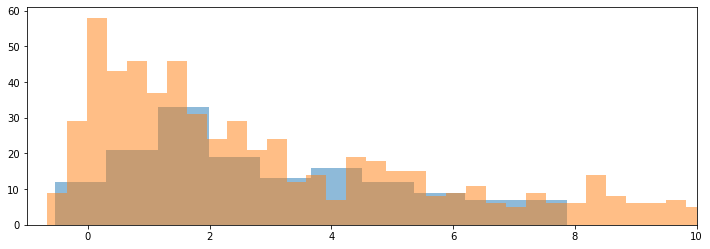

In [223]:
#Проверим распределение таргетов
plt.figure(figsize=[12.0, 4.0])
plt.hist(test_["UpLift"], bins=10, label='Тест', alpha = 0.5, align='left')
plt.hist(train_target["UpLift"], bins=100, label='Трейн', alpha = 0.5, align='left')
plt.xlim(-1, 10)

In [224]:
test_[['UpLift']].to_csv('submission/prediction21.csv', index=True)
compression_opts = dict(method='zip', archive_name='prediction21.csv')
test_[['UpLift']].to_csv('submission/prediction21.zip', index=True, compression=compression_opts)

Text(0.5, 0, 'Importance')

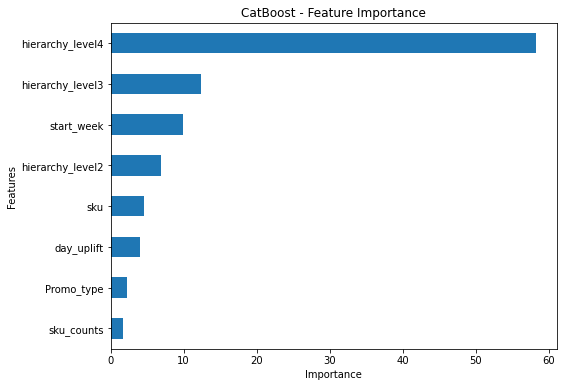

In [178]:
fea_imp = pd.DataFrame({'imp': cat_train.feature_importances_, 'col': feature_col})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(8, 6), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

In [185]:
%%time
eval_set = Pool(X_valid, y_valid, cat_list)
cat_params = {"loss_function" : 'RMSE', "eval_metric" : 'MAE',  'learning_rate': 0.01, 'depth': 4, 
              'random_state' : 42,  'task_type' : 'GPU'}

features = feature_col
num_folds = 5
folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
    print("fold n°{}".format(fold_ + 1))
    trn_data = Pool(X_train.iloc[trn_idx][features], label=y_train.iloc[trn_idx], cat_features=cat_list) 
    val_data = Pool(X_train.iloc[val_idx][features], label=y_train.iloc[val_idx], cat_features=cat_list) 
    clf = catboost.train(params=cat_params, pool = trn_data, eval_set=val_data, num_boost_round=2000, 
                         early_stopping_rounds=200, verbose_eval=500) 
    oof[val_idx] = clf.predict(val_data)
    
    print('Fold %2d MAE : %.6f' % (fold_ + 1, mean_absolute_error(y_train.iloc[val_idx], oof[val_idx])))    
    #Прогноз
    test_data = Pool(X_test[features], cat_features=cat_list) 
    predictions += clf.predict(test_data) / folds.n_splits
print('Oof MAE : %.6f' % (mean_absolute_error(y_train, oof)))

fold n°1
0:	learn: 3.5561530	test: 3.4320372	best: 3.4320372 (0)	total: 11.6ms	remaining: 23.2s
500:	learn: 2.2354823	test: 2.0726744	best: 2.0726744 (500)	total: 4.53s	remaining: 13.6s
1000:	learn: 2.1242092	test: 1.9913498	best: 1.9913472 (999)	total: 8.86s	remaining: 8.84s
1500:	learn: 2.0707073	test: 1.9501404	best: 1.9501404 (1500)	total: 13.3s	remaining: 4.42s
1999:	learn: 2.0376464	test: 1.9240754	best: 1.9240754 (1999)	total: 17.7s	remaining: 0us
bestTest = 1.924075428
bestIteration = 1999
Fold  1 MAE : 1.924075
fold n°2
0:	learn: 3.5422410	test: 3.4989234	best: 3.4989234 (0)	total: 9.94ms	remaining: 19.9s
500:	learn: 2.2757899	test: 2.0222200	best: 2.0222200 (500)	total: 4.44s	remaining: 13.3s
1000:	learn: 2.1115706	test: 1.8680571	best: 1.8680571 (1000)	total: 8.75s	remaining: 8.73s
1500:	learn: 2.0346187	test: 1.8051951	best: 1.8051951 (1500)	total: 13.1s	remaining: 4.34s
1999:	learn: 1.9703704	test: 1.7504791	best: 1.7504791 (1999)	total: 17.4s	remaining: 0us
bestTest = 1.7

In [581]:
test['UpLift'] = predictions

In [ ]:
test_group = test.groupby('Offer_ID').agg({'UpLift':'mean'})
#чтобы упорядочить
test_ = pd.merge(test_target[['Offer_ID']], test_group, how='left', on=['Offer_ID'])
test_.set_index('Offer_ID', inplace=True)
test_['UpLift']=test_['UpLift']-2
test_

In [ ]:
test_[['UpLift']].to_csv('submission/prediction20.csv', index=True)
compression_opts = dict(method='zip', archive_name='prediction20.csv')
test_[['UpLift']].to_csv('submission/prediction20.zip', index=True, compression=compression_opts)